In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn

In [4]:
dataset = pd.read_csv('chips.txt', header=None)
dataset.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [6]:
set(dataset[2])

{0, 1}

In [7]:
zeroLabels = dataset[dataset[2] == 0]
oneLabels = dataset[dataset[2] == 1]

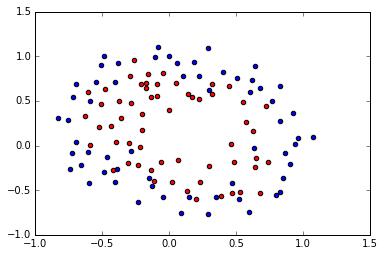

In [9]:
plt.scatter(zeroLabels[0], zeroLabels[1], c='blue')
plt.scatter(oneLabels[0], oneLabels[1], c='red')

In [92]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import BallTree

class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, convert=lambda x: x, n_neighbors=3, metric="euclidean"):
        self.convert = convert
        self.n_neighbors = n_neighbors
        self.metric = metric
    
    def set_params(self, **params):
        self.convert = params["convert"]
        self.n_neighbors = params["n_neighbors"]
        self.metric = params["metric"]
        return self
        
    def get_params(self, deep=None):
        return {"convert": self.convert, "n_neighbors": self.n_neighbors, "metric": self.metric}
        
    def fit(self, X, y):
        X = np.apply_along_axis(self.convert, 1, X)
        self.tree = BallTree(X, metric=self.metric)
        self.y = np.array(y)
        self.labels = np.array(list(set(y)))
    
    def predict(self, X):
        X = np.apply_along_axis(self.convert, 1, X)
        nearest = self.tree.query(X, k=self.n_neighbors, return_distance=False)
        counts = []
        for label in self.labels:
            bools = np.where(self.y[nearest] == label, 1, 0)
            counts.append(np.sum(bools, axis=1))
        #counts = [np.where(self.y[nearest] == label, 1, 0).sum(axis=1) for label in self.labels]
        return self.labels[np.argmax(np.array(counts), axis=0)]

In [71]:
from sklearn.cross_validation import cross_val_score, train_test_split

classifier = KNNClassifier()
xTrain, xTest, yTrain, yTest = train_test_split(dataset[[0,1]], dataset[2])
classifier.fit(xTrain, yTrain)
classifier.score(xTest, yTest)

0.66666666666666663

In [72]:
cross_val_score(KNNClassifier(), dataset[[0,1]], dataset[2], cv=5)

array([ 0.625     ,  0.25      ,  0.58333333,  0.69565217,  0.73913043])

In [84]:
covMatrix = np.cov(dataset[[1,2]].T)
covMatrix

array([[ 0.27013269,  0.00148653],
       [ 0.00148653,  0.25206432]])

In [117]:
from sklearn.grid_search import GridSearchCV
from numpy.linalg import norm
from scipy.spatial.distance import mahalanobis as mahalDistance

def prettyPrint(name):
    def annotate(f):
        class Transform:
            def __repr__(self): return name
            def __call__(self, x): return f(x)
        return Transform()
    return annotate

@prettyPrint("Linear") 
def linear(x): return x
@prettyPrint("Euclidean") 
def euclidean(x): return np.append(x, norm(x - mean))
@prettyPrint("Mahalanobis") 
def mahalanobis(x): return np.append(x, mahalDistance(x, mean, covMatrix))
@prettyPrint("Manhattan") 
def manhattan(x): return (x - mean).abs().sum()
@prettyPrint("ExpEuclidean") 
def expEuclidean(x): return np.append(x, np.exp(norm(x - mean)))
@prettyPrint("ExpMahalanobis") 
def expMahalanobis(x): return np.append(x, np.exp(mahalDistance(x, mean, covMatrix)))
@prettyPrint("Polar")
def polar(x):
    r = x - mean
    return np.array([norm(r), abs(np.arctan2(r[0], r[1]))])

mean = dataset[[0,1]].mean()
KNNSearchCV = GridSearchCV(KNNClassifier(), {"convert": 
                                             [linear, euclidean, mahalanobis, expEuclidean, expMahalanobis, polar],
                                           "metric": ["euclidean", "manhattan"],
                                           "n_neighbors": [2, 3, 5, 7]}, cv=5)
KNNSearchCV.fit(dataset[[0,1]], dataset[2])
print(KNNSearchCV.best_score_, KNNSearchCV.best_estimator_)
KNNSearchCV.grid_scores_

0.669491525424 KNNClassifier(convert=ExpEuclidean, metric='manhattan', n_neighbors=3)


[mean: 0.60169, std: 0.14441, params: {'metric': 'euclidean', 'convert': Linear, 'n_neighbors': 2},
 mean: 0.57627, std: 0.17299, params: {'metric': 'euclidean', 'convert': Linear, 'n_neighbors': 3},
 mean: 0.50000, std: 0.14207, params: {'metric': 'euclidean', 'convert': Linear, 'n_neighbors': 5},
 mean: 0.48305, std: 0.14669, params: {'metric': 'euclidean', 'convert': Linear, 'n_neighbors': 7},
 mean: 0.60169, std: 0.16464, params: {'metric': 'manhattan', 'convert': Linear, 'n_neighbors': 2},
 mean: 0.57627, std: 0.14780, params: {'metric': 'manhattan', 'convert': Linear, 'n_neighbors': 3},
 mean: 0.51695, std: 0.14083, params: {'metric': 'manhattan', 'convert': Linear, 'n_neighbors': 5},
 mean: 0.51695, std: 0.12022, params: {'metric': 'manhattan', 'convert': Linear, 'n_neighbors': 7},
 mean: 0.60169, std: 0.16464, params: {'metric': 'euclidean', 'convert': Euclidean, 'n_neighbors': 2},
 mean: 0.61864, std: 0.19073, params: {'metric': 'euclidean', 'convert': Euclidean, 'n_neighbors'